In this Notebook:

- IoU and NMS
- U-Net and Transposed Convolution
- Vision Transformer vs. ResNet

In [1]:
# @title **Auriliary Functions**

import cv2
import matplotlib.pyplot as plt

def visualize_bboxes(predictions, image_path):
    input_height = 416
    input_width = 416
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (input_height, input_width), interpolation=cv2.INTER_CUBIC)

    for box in predictions.items():
        bbox = box[1]["coordinates"]
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        # Add label and score
        label = box[1]["label"]
        score = box[1]["confidence"]
        # reduce font size
        cv2.putText(image, f"{label} {score:.2f}", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    plt.imshow(image)
    plt.show()

# Intersection over Union (IoU) and Non Max Suppression (NMS)

In this exercise, you will need to implement two functions: one for calculating the IoU and the other for calculating the NMS. We will use the output of the Yolov2 Tiny network.[[1]](https://pjreddie.com/darknet/yolov2/#google_vignette) [[2]](https://github.com/pjreddie/darknet/tree/master).



In [2]:
#@title Bounding Boxes, corresponding scores and label.
yolo_result = {
    "B-Box 1": {
        "coordinates": [55, 165, 182, 384],
        "confidence": 0.7966278750564337,
        "label": "dog"
    },
    "B-Box 2": {
        "coordinates": [241, 66, 376, 131],
        "confidence": 0.776848532752125,
        "label": "car"
    },
    "B-Box 3": {
        "coordinates": [243, 54, 369, 126],
        "confidence": 0.7657397316170889,
        "label": "car"
    },
    "B-Box 4": {
        "coordinates": [79, 118, 324, 305],
        "confidence": 0.5008548604882253,
        "label": "bicycle"
    },
    "B-Box 5": {
        "coordinates": [80, 168, 190, 371],
        "confidence": 0.37776975240976346,
        "label": "dog"
    },
    "B-Box 6": {
        "coordinates": [48, 122, 306, 309],
        "confidence": 0.3154387526026568,
        "label": "bicycle"
    },
    "B-Box 7": {
        "coordinates": [56, 199, 170, 387],
        "confidence": 0.3066324496949219,
        "label": "cat"
    },
    "B-Box 8": {
        "coordinates": [270, 63, 384, 135],
        "confidence": 0.2797399869669993,
        "label": "car"
    },
    "B-Box 9": {
        "coordinates": [266, 50, 383, 130],
        "confidence": 0.2444611055591334,
        "label": "car"
    },
    "B-Box 10": {
        "coordinates": [222, 52, 335, 118],
        "confidence": 0.20743512045895154,
        "label": "car"
    }
}

> ### **Exercise:** Implement the IoU function

1. Calculate the coordinates of the intersection area:
- $x_{0}^{I} = max(x_{0}, y_{0})$
- $y_{0}^{I} = max(x_{1}, y_{1})$
- $x_{1}^{I} = min(x_{2}, y_{2})$
- $y_{1}^{I} = min(x_{3}, y_{3})$

2. Check if there is an intersection

- If $x_{1}^{I} - x_{0}^{I}$ or  $y_{1}^{I} - y_{0}^{I}$
then $A \cap B = 0$

3. Calculate the Intersection

- $A \cap B = (x_{1}^{I} - x_{0}^{I}) \cdot (y_{1}^{I} - y_{0}^{I})$

4. Calculate the are of both rectangles
5. Calculate the Union Area

- $A \cup B = area_A + area_B - A \cap B$

6. Finally:

- $IoU = \frac{A \cap B}{A \cup B}$

In [3]:
def iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    width_inter = max(0, x2_inter - x1_inter)
    height_inter = max(0, y2_inter - y1_inter)
    area_inter = width_inter * height_inter

    width_box1 = box1[2] - box1[0]
    height_box1 = box1[3] - box1[1]
    area_box1 = width_box1 * height_box1

    width_box2 = box2[2] - box2[0]
    height_box2 = box2[3] - box2[1]
    area_box2 = width_box2 * height_box2

    area_union = area_box1 + area_box2 - area_inter

    iou_value = area_inter / area_union if area_union > 0 else 0

    return iou_value

> ### **Exercise:** Implement the Non Max Suppression (NMS) function

1. Select the bounding box with the highest confidence score
2. Calculate the IoU with the rest of the bounding boxes
3. If the IoU is higher than a threshold, remove the bounding box
4. Repeat the process with the next bounding box

In [4]:
def nms(predictions, iou_threshold):

    predictions = sorted(predictions, key=lambda x: x[4], reverse=True)
    nms_predictions = []
    while len(predictions) > 0:
        best_pred = predictions[0]
        nms_predictions.append(best_pred)
        if len(predictions) == 1:
            break
        remaining_preds = []
        for pred in predictions[1:]:
            current_iou = iou(best_pred[:4], pred[:4])
            if current_iou < iou_threshold:
                remaining_preds.append(pred)

        predictions = remaining_preds

    return nms_predictions

Download this image:

https://drive.google.com/file/d/1rE8zlUtL7gviyUng5FPfvQ0IBtltzI4u/view?usp=sharing

After NMS:


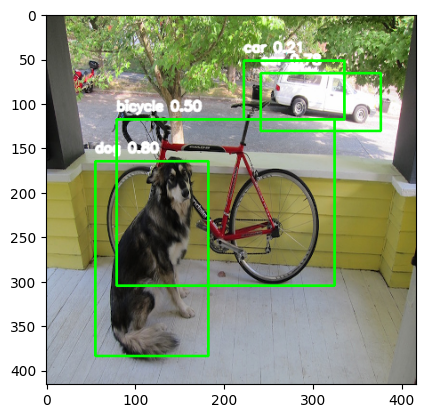

In [6]:
# Create a mapping of labels to class IDs
unique_labels = set()
for box in yolo_result.values():
    unique_labels.add(box["label"])

label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {v: k for k, v in label_to_id.items()}

# Convert YOLO results to the list format
predictions = []
for box_name, box_data in yolo_result.items():
    coords = box_data["coordinates"]
    confidence = box_data["confidence"]
    label = box_data["label"]
    class_id = label_to_id[label]

    predictions.append([coords[0], coords[1], coords[2], coords[3], confidence, class_id])

# Apply NMS with a threshold of 0.5
iou_threshold = 0.5
filtered_predictions = nms(predictions, iou_threshold)

# Convert filtered predictions back to YOLO format
filtered_yolo_result = {}
for i, pred in enumerate(filtered_predictions):
    x1, y1, x2, y2, confidence, class_id = pred
    label = id_to_label[class_id]

    filtered_yolo_result[f"B-Box {i+1}"] = {
        "coordinates": [int(x1), int(y1), int(x2), int(y2)],
        "confidence": confidence,
        "label": label
    }

# Then visualize the filtered detections
print("After NMS:")
visualize_bboxes(filtered_yolo_result, 'dog.jpg')

Original detections:


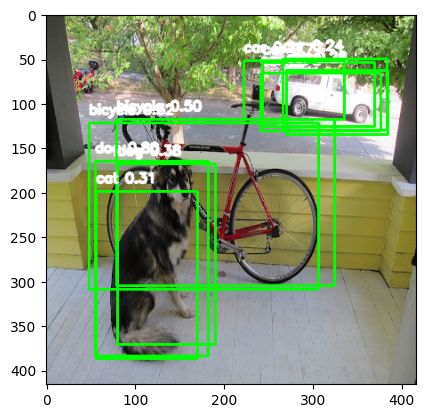

In [7]:
#### Plot Bboxes and predictions
print("Original detections:")
visualize_bboxes(yolo_result, 'dog.jpg')

# Transposed Convolution

#### **Exercise:** Generate the Transposed Convolution function

You can consult these references:

* [Calculating-output-size-of-convolutions](http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html)

* [Transpose Convolution](https://blog.paperspace.com/transpose-convolution/)

In [8]:
def trans_conv(x, kernel, stride=(1,1), padding=1):
    H_in, W_in = x.shape
    kH, kW = kernel.shape

    H_out = (H_in - 1) * stride - 2 * padding + kH
    W_out = (W_in - 1) * stride - 2 * padding + kW

    expanded_shape = ((H_in - 1) * stride + 1, (W_in - 1) * stride + 1)
    X_expanded = np.zeros(expanded_shape)
    for i in range(H_in):
        for j in range(W_in):
            X_expanded[i * stride, j * stride] = X[i, j]

    H_exp, W_exp = X_expanded.shape
    Y_full = np.zeros((H_exp + kH - 1, W_exp + kW - 1))
    for i in range(H_exp):
        for j in range(W_exp):
            Y_full[i : i + kH, j : j + kW] += X_expanded[i, j] * K


    if padding > 0:
        Y = Y_full[padding : -padding, padding : -padding]
    else:
        Y = Y_full

    return Y

# Vision Transformer vs. VGG

In [ ]:
#@title Imports
import glob
import random
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1] range
])

def filter_indices_with_limits(dataset, class_sample_limits):
    indices = []
    class_counts = {cls: 0 for cls in class_sample_limits.keys()}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_name = dataset.classes[label]
        if class_name in class_sample_limits:
            if class_counts[class_name] < class_sample_limits[class_name]:
                indices.append(i)
                class_counts[class_name] += 1
            if all(class_counts[cls] >= limit for cls, limit in class_sample_limits.items()):
                break
    return indices


trainset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True, transform=transform)

train_limits = {'airplane': 500, 'automobile': 500, 'bird': 500}
test_limits = {'airplane': 100, 'automobile': 100, 'bird': 100}

train_indices = filter_indices_with_limits(trainset, train_limits)
trainset_filtered = Subset(trainset, train_indices)

test_indices = filter_indices_with_limits(testset, test_limits)
testset_filtered = Subset(testset, test_indices)

trainloader = DataLoader(trainset_filtered, batch_size=64, shuffle=True)
testloader = DataLoader(testset_filtered, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data/
Files already downloaded and verified


In [ ]:
#@title Fine-Tunning
from torchvision import models

vgg19 = models.vgg19(pretrained=True)
model = vgg19
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 3)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 88.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#@title Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
#@title Training

num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.7127436511218548
Epoch 2, Loss: 0.19367134291678667
Epoch 3, Loss: 0.10093048975492518


In [ ]:
#@title Test the VGG19 model
correct_vgg = 0
total_vgg = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_vgg += labels.size(0)
        correct_vgg += (predicted == labels).sum().item()

# Guardar la precisión para comparación posterior
vgg_accuracy = 100 * correct_vgg / total_vgg
print(f"Accuracy of the VGG19 model on the test images: {vgg_accuracy}%")


Accuracy of the VGG19 model on the test images: 93.33333333333333%


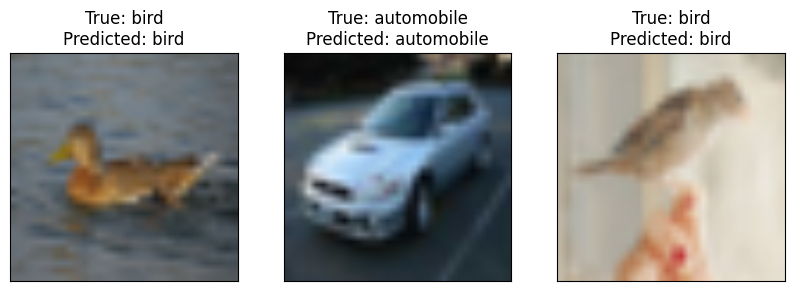

In [ ]:
import matplotlib.pyplot as plt

model.eval()

# Get a batch of test images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

classes = trainset.classes[0:3]
fig = plt.figure(figsize=(10, 4))
for idx in range(3):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx]]}\nPredicted: {classes[predicted[idx]]}")

plt.show()

# Guardar algunas predicciones para comparar más tarde si lo deseas
vgg_predictions = predicted.cpu().numpy()

## ViT

### **Exercise:** Fine-Tuning ViT with our Cifar-10 dataset.

In [ ]:
#@title Load the Vision Transformer model
!pip install vit-pytorch
# You can use one of this ViT models instead: https://pytorch.org/vision/main/models/vision_transformer.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
from torchvision import models
import torch
from torch import nn
import torch.optim as optim

vit_model = models.vit_b_16(weights='IMAGENET1K_V1')


for param in vit_model.parameters():
    param.requires_grad = False


num_features = vit_model.heads.head.in_features
vit_model.heads.head = nn.Linear(num_features, 3)

for param in vit_model.heads.parameters():
    param.requires_grad = True

vit_model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vit_model.parameters()), lr=0.00001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

print("Fine-tuning completed.")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 59.1MB/s]


Epoch 1, Loss: 1.1839402467012405
Epoch 2, Loss: 1.1519920229911804
Epoch 3, Loss: 1.122880165775617
Fine-tuning completed.


Accuracy of the ViT model on the test images: 39.666666666666664%


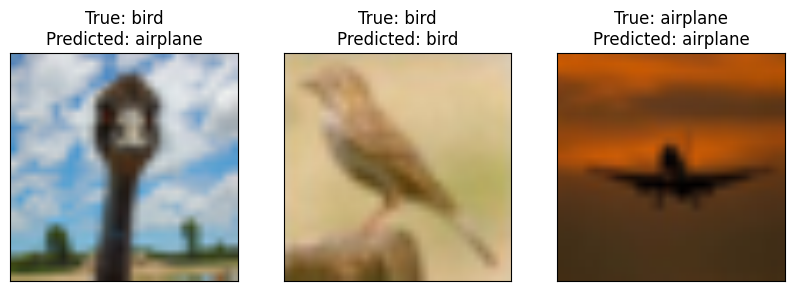


--- Comparación de modelos ---
VGG19 accuracy: 93.33%
ViT accuracy: 39.67%
Diferencia (ViT - VGG19): -53.67%


In [ ]:
#@title Test the ViT model
correct_vit = 0
total_vit = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_vit += labels.size(0)
        correct_vit += (predicted == labels).sum().item()

# Guardar la precisión para comparación
vit_accuracy = 100 * correct_vit / total_vit
print(f"Accuracy of the ViT model on the test images: {vit_accuracy}%")

vit_model.eval()

# Get a batch of test images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = vit_model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

classes = trainset.classes[0:3]
fig = plt.figure(figsize=(10, 4))
for idx in range(3):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx]]}\nPredicted: {classes[predicted[idx]]}")

plt.show()

# Guardar algunas predicciones
vit_predictions = predicted.cpu().numpy()

# Comparar resultados de VGG19 vs ViT
print("\n--- Comparación de modelos ---")
print(f"VGG19 accuracy: {vgg_accuracy:.2f}%")
print(f"ViT accuracy: {vit_accuracy:.2f}%")
print(f"Diferencia (ViT - VGG19): {vit_accuracy - vgg_accuracy:.2f}%")

# Opcional: Visualización de comparación
if hasattr(locals(), 'vgg_predictions'):
    # Crear tabla de comparación
    comparison_indices = [0, 1, 2]  # Mostrar las primeras 3 imágenes
    comparison_data = []

    for idx in comparison_indices:
        true_label = classes[labels[idx]]
        vgg_pred = classes[vgg_predictions[idx]]
        vit_pred = classes[vit_predictions[idx]]
        correct_vgg = vgg_pred == true_label
        correct_vit = vit_pred == true_label

        comparison_data.append({
            'Image': idx,
            'True': true_label,
            'VGG19': vgg_pred,
            'VGG19_Correct': correct_vgg,
            'ViT': vit_pred,
            'ViT_Correct': correct_vit
        })

    # Imprimir comparación
    print("\nComparación de predicciones en algunos ejemplos:")
    for item in comparison_data:
        print(f"Imagen {item['Image']}:")
        print(f"  Etiqueta real: {item['True']}")
        print(f"  Predicción VGG19: {item['VGG19']} {'✓' if item['VGG19_Correct'] else '✗'}")
        print(f"  Predicción ViT: {item['ViT']} {'✓' if item['ViT_Correct'] else '✗'}")
        print()

### **Exercise:** Compare the results by the VGG model and the ViT model.

The performance difference between VGG19 (93.33%) and ViT (39.67%) on our CIFAR-10 subset reveals fundamental architectural strengths and weaknesses:

- Training efficiency: VGG19's loss rapidly decreased (0.71→0.10) while ViT barely improved (1.18→1.12)

- Architectural advantages: CNNs like VGG19 have built-in image-specific biases (locality, translation invariance) that ViTs lack

- Data requirements: ViTs are notoriously data-hungry, and our 500 images per class is insufficient for effective learning

- Transfer learning effectiveness: While both used pre-trained weights, VGG19's architecture transfers more effectively to small datasets

This aligns with research showing CNNs often outperform Transformers on smaller datasets where their inductive biases provide significant advantages.

Despite the current popularity of Transformers, our experiment demonstrates there's no universally superior architecture. CNNs like VGG19 remain extremely effective for vision tasks with limited data, while ViTs require abundant data to excel. This contrast reinforces the importance of selecting architectures based on the specific characteristics of each problem, rather than blindly following current trends.